# Example: 2D Koopman - Part 2/3

- Author: Dr. Daning Huang
- Date: 08/04/2025
- Updated: 12/08/2025

As the second part of this example, we show two things:

- More refined options in the NODE optimizer regarding sweeping
- Using the NODE optimizer for discrete-time models

## Preparation

As usual, a few imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import KBF
from dymad.training import NODETrainer
from dymad.utils import plot_summary, plot_trajectory, TrajectorySampler

We already have data from Part 1, so no data generation here.  The config file `kp_model.yaml` is the same, too.

Next, the specifications for modeling and training:

In [2]:
mdl_kb = {
    "name" : 'kp_model',
    "encoder_layers" : 2,
    "decoder_layers" : 2,
    "hidden_dimension" : 32,
    "koopman_dimension" : 4,
    "autoencoder_type": "cat",
    "activation" : "prelu",
    "weight_init" : "xavier_uniform"}
crit = {
        "dynamics" : {"weight" : 1.0},
        "recon" : {"weight" : 1.0}}
trn_ref = {
    "n_epochs": 400,
    "save_interval": 20,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "ode_method": "dopri5",
    "ode_args": {
        "rtol": 1.e-7,
        "atol": 1.e-9
    },
    "sweep_epoch_step": 100,
    "sweep_lengths": [10, 20, 30, 50],
}

## Sweeping Options

By default, we choose a sweeping length sequence of `[10, 20, 30, 50]`, and the length changes every 100 epochs.  Recall that this means:

- Start training the model using the first 10 steps of trajectories.
- When 100 epochs are reached, switch to using the first 20 steps of trajectories.
- Then 30 and 50.
- Then the optimization continues until the maximum number of epochs is achieved.

Now more options are explored.

> Note that the goal here is to show the tuning of options, so there is no guarantee on the accuracy of the trained models.

First, let's define the default case as `nd1`.

In [3]:
trn_nd1 = {}
trn_nd1.update(trn_ref)

The second case below adds a tolerance sequence.  Sometimes over a short length the loss may have already sufficiently reduced, and training more using the short length might not help as much; in this case we can set the tolerance, and let the optimizer move on to the next length earlier.

In [4]:
trn_nd2 = {
    "sweep_tols": [0.4, 0.1],
}
trn_nd2.update(trn_ref)

The third case modifies the sweeping mode as `full`.  In the previous default case, when a tolerance is achieved at the last sweeping length and the optimizer switches to the next tolerance, the sweeping length stays the same.  In other words, when a later length is chosen, the earlier lengths are never used again.

In this third case, the sweeping length resets once the tolerance is changed.

In [5]:
trn_nd3 = {
    "sweep_tols": [0.4, 0.1],
    "sweep_mode": "full",
}
trn_nd3.update(trn_ref)

The last case is somewhat different from the previous two.  It defines a "chop" mode of `unfold`.  In the first case, for length `N`, only the first `N` steps of the trajectories are used.  But in many cases, the rest of the trajectories could be used for training too.

The options below turn on the use of these trajectories.  The option `chop_step` specifies the overlap between trajectory segments.  For example, `0.5` means 50% overlap (so the overlap changes with lengths).  The `chop_step` can be an integer too, which specifies a fixed number of overlapping steps.

> The `unfold` mode might not work for some cases, e.g., when there are unknown states in the dynamics unless one solves the ODE starting from beginning - this means one cannot start from an arbitrary location on the trajectory.

In [6]:
trn_nd4 = {
    "chop_mode": "unfold",
    "chop_step": 0.5,
}
trn_nd4.update(trn_ref)

### Comparison

Next we are ready to train and compare the above cases.

In [7]:
trn_opts = [trn_nd1, trn_nd2, trn_nd3, trn_nd4]
config_path = 'kp_model.yaml'

IDX = [0, 1, 2, 3]

for i in IDX:
    opt = {"model": mdl_kb, "criterion": crit, "training": trn_opts[i]}
    opt["model"]["name"] = f"kp_nd{i+1}"
    trainer = NODETrainer(config_path, KBF, config_mod=opt)
    trainer.train()

For comparison, we will only look at the loss curves.

- `nd1`: The reference case.  A discontinuity appears every 100 steps, showing the switching of sweeping length.
- `nd2`: With tolerance.  The discontinuity appears much earlier than 100 steps, as the length switches once a tolerance is achieved (in this case 0.4).  When the last length is reached, it is kept for the rest of the training.  Once the last tolerance is reached, the training stops.
- `nd3`: With tolerance and full sweeping.  After the first set of discontinuities (due to tolerance 0.4), the tolerance switches to 0.1 **and** the length switches back to 10.  Hence the second set of discontinuities shows up for tolerance 0.1.

> Since shorter lengths are faster to run for one epoch, selecting the correct sweeping scheme can help accelerate the convergence.

nd1 Epoch time: 0.08573960721492767
nd2 Epoch time: 0.06466180539270591
nd3 Epoch time: 0.057021134141562645


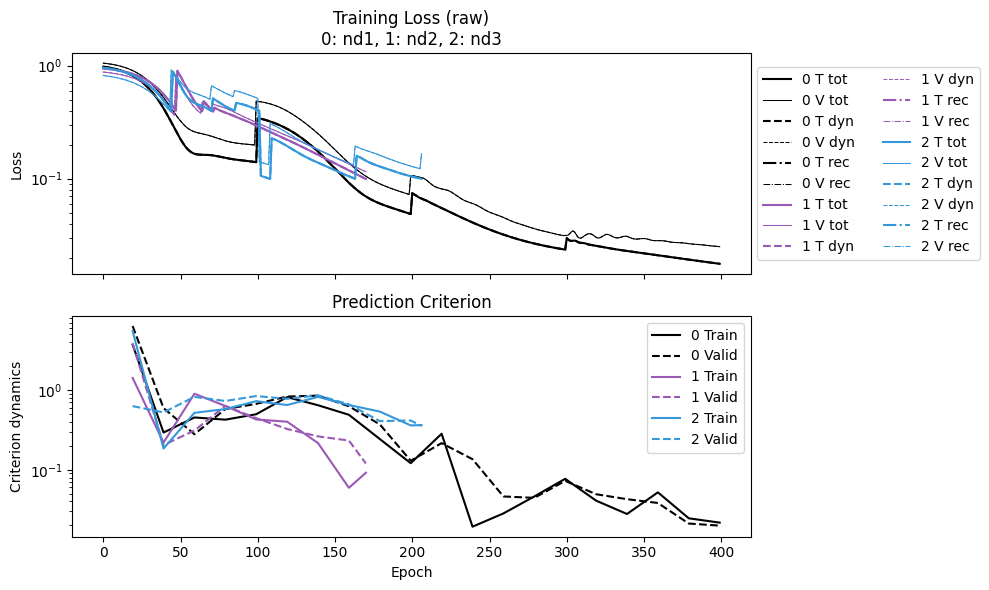

In [8]:
IDX = [0, 1, 2]
labels = [f"nd{i+1}" for i in IDX]
npz_files = [f'kp_{l}' for l in labels]
npzs = plot_summary(npz_files, labels=labels, ifscl=False, ifclose=False)
for j, i in enumerate(IDX):
    print(f"nd{i+1} Epoch time:", npzs[j]['avg_epoch_time'])

Lastly, looking at `nd4`:

- The loss starts 1.5 orders of magnitude lower than `nd1`, and ends with an even bigger difference.  This is due to the dramatically increased number of data samples in the unfold mode.
- But the epoch time shows a clear trade-off: `nd4` takes much more time than `nd1`.

> The rule of thumb is to fill in the memory of your device as much as possible, using whichever modes.  This might mean `initial` mode (the default) on CPU, and `unfold` mode on GPU.

nd1 Epoch time: 0.08573960721492767
nd4 Epoch time: 0.31477461695671083


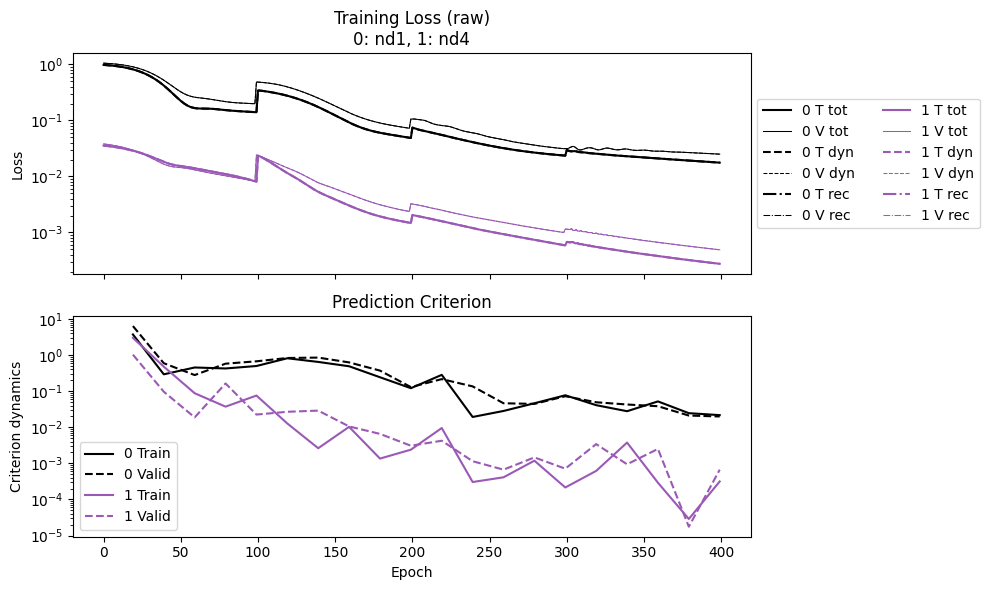

In [9]:
IDX = [0, 3]
labels = [f"nd{i+1}" for i in IDX]
npz_files = [f'kp_{l}' for l in labels]
npzs = plot_summary(npz_files, labels=labels, ifscl=False, ifclose=False)
for j, i in enumerate(IDX):
    print(f"nd{i+1} Epoch time:", npzs[j]['avg_epoch_time'])

## Discrete-Time Model

It might sound strange to include this topic in this example, as the rest are all for continuous-time models.  But below we will show how easy it is to switch to a discrete-time one, even with the same NODE optimizer.

The ideas are two-fold.  For modeling, the continuous-time (CT) and discrete-time (DT) versions would be, respectively,
$$
z = f_{enc}(x),\quad \dot{z} = f_{CT}(z_k,u_k) ,\quad x_k = f_{dec}(z_k)
$$
and
$$
z_k = f_{enc}(x_k),\quad z_{k+1} = f_{DT}(z_k,u_k) ,\quad x_k = f_{dec}(z_k)
$$
And if one uses the same NN architecture for $f_{CT}$ and $f_{DT}$, then there would be no way to differentiate the two models from the NN perspective.

For training, underlying NODE trainer, we simply implement a `predict` function that solves an initial value problem (IVP) and can be back-propagated.  If a model provides a DT IVP, then the NODE thus trained would produce a DT model.

Therefore, all we need to do is to replace a CT model (like `KBF`) with a DT model that has a `predict` function for DT dynamics.

In this example we will use the DT version of KBF, as imported below.

In [10]:
from dymad.models import DKBF

The options are nearly the same for the `nd4` case above.  We just modify the sweep lengths.  The ODE solver options are not needed and thus removed.

In [11]:
trn_opt = {
    "n_epochs": 1000,
    "save_interval": 20,
    "load_checkpoint": False,
    "learning_rate": 5e-3,
    "decay_rate": 0.999,
    "sweep_epoch_step": 200,
    "sweep_lengths": [2, 4, 6, 8, 10],
    "chop_mode": "unfold",
    "chop_step": 0.5,
}

Then training - again nearly the same, even the `NODETrainer`.

In [12]:
opt = {"model": mdl_kb, "criterion": crit, "training": trn_opt}
opt["model"]["name"] = "kp_dt"
trainer = NODETrainer(config_path, DKBF, config_mod=opt)
trainer.train();

Then plotting the loss to check convergence.

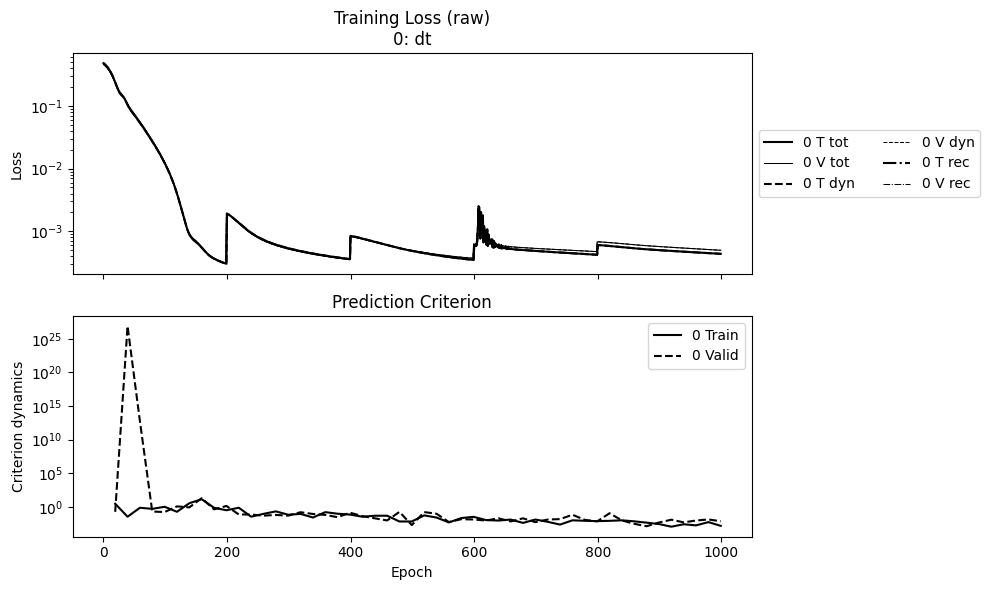

In [13]:
npz_files = ['kp_dt']
npzs = plot_summary(npz_files, labels=['dt'], ifscl=False, ifclose=False)

Lastly the prediction on a new test case - an OK job given that we did not tune the model extensively yet.

> You might want to try different autoencoder options, e.g., `res`, to improve the model.

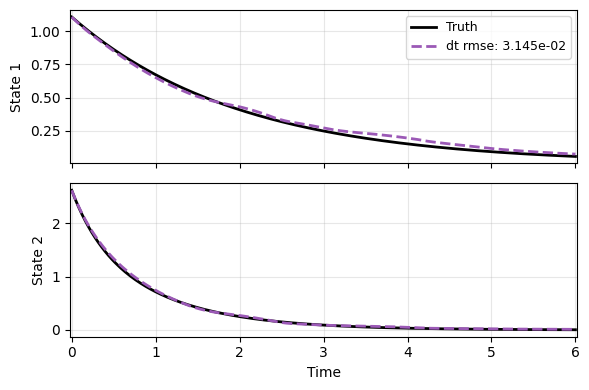

In [15]:
N = 301
t_grid = np.linspace(0, 6, N)

mu = -0.5
lm = -3
def f(t, x):
    _d = np.array([mu*x[0], lm*(x[1]-x[0]**2)])
    return _d

sampler = TrajectorySampler(f, config='kp_data.yaml')
ts, xs, ys = sampler.sample(t_grid, batch=1)
x_data = xs[0]
t_data = ts[0]

_, prd_func = load_model(DKBF, 'kp_dt.pt')
with torch.no_grad():
    pred = prd_func(x_data, t_data)

labels = ['Truth', 'dt']
plot_trajectory(
    np.array([x_data, pred]), t_data, "KP",
    labels=labels, ifclose=False);